# Libraries

In [0]:
%pip install pingouin
%pip install squarify


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

import pingouin as pg
import itertools

from PIL import Image

import squarify

import string

reference_date = pd.to_datetime("2023-08-01 00:00:00")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [0]:
#TABLE CREATED USING QUERY ON ORIGINAL DATABASE
#df_spark = spark.table("workspace.default.user_agg_tab")

#TABLE CREATED USING QUERY ON SESSION TABLE
df_spark = spark.table("workspace.default.usertab_from_sessiontab_spark") #TABLE SAVED IN "users_RawTab.csv"
df = df_spark.toPandas()

#replace age_bin coming from the delta table as dictionaries with actual pd.cut intervals
bins_range = [df.age_in_2023.min(), 20, 30, 40, 50, 60, 70, 80, 90]
df['age_bin'] = pd.cut(df.age_in_2023, bins=bins_range, right=False)

In [0]:
df_spark = spark.table("workspace.default.df_sessions_tab") #TABLE SAVED IN "sessions_preprocessed.csv"
df_sessions = df_spark.toPandas()

In [0]:
df.age_bin.value_counts()

age_bin
[40, 50)    2124
[30, 40)    1508
[50, 60)    1038
[20, 30)     697
[17, 20)     307
[60, 70)     225
[70, 80)      87
[80, 90)      12
Name: count, dtype: int64

# Customized Functions

In [0]:
#function that calculate the effect size of a continuous variable with respect to a categorical variable
def effect_size_cont_disc(df, feat_cont, feat_discr):
    categor_list = list(df[feat_discr].value_counts().index)
    combin = list(itertools.combinations(categor_list, 2))
    print(f"--- {feat_cont} vs {feat_discr} ----------------")
    for x,y in combin:
        a = df.loc[df[feat_discr]==x, feat_cont]
        b = df.loc[df[feat_discr]==y, feat_cont]
        d = np.abs(pg.compute_effsize(a, b, eftype='cohen'))
        print(f"{x} vs {y}:  d={d} ({inter_eff(d)})")

#how to interpret effect size
def inter_eff(d):
    if d < 0.2:
        return "negligible"
    elif d < 0.5:
        return "small"
    elif d < 0.8:
        return "medium"
    else:
        return "large"

# Check & Adjustment

In [0]:
#df.info()

In [0]:
#converting date from objects to date format
#NO NEED FOR THIS COLUMN IF USERTAB FROM SESSIONTAB IS USED

#df['birthdate'] = pd.to_datetime(df['birthdate'])
#df['sign_up_date'] = pd.to_datetime(df['sign_up_date'])

In [0]:
#creating age column
#NO NEED FOR THIS COLUMN IF USERTAB FROM SESSIONTAB IS USED

#df['age_in_2023'] = 2025 - df['birthdate'].dt.year

In [0]:
#df.describe()

#RFM

##Recency

In [0]:
df.date_last_booking_travelled.isnull().sum()

np.int64(564)

In [0]:
#calculation days since last session "booked and travelled"
days_since_lastBooking_travelled =(reference_date.date() - df.date_last_booking_travelled.dt.date).apply(lambda x: x.days if pd.notnull(x) else np.nan)

In [0]:
days_since_lastBooking_travelled.min()

np.float64(12.0)

In [0]:
days_since_lastBooking_travelled.max()

np.float64(209.0)

In [0]:
#calculation of quintiles
quintiles_R = days_since_lastBooking_travelled.quantile([0.2, 0.4, 0.6, 0.8])
quintiles_R

0.2     31.0
0.4     59.0
0.6     97.0
0.8    138.0
Name: date_last_booking_travelled, dtype: float64

In [0]:
#definition function to assign x to quintiles
def quintile_assign_inver(quintiles, x):
    if x <= quintiles[0.2]:
        return 5
    elif x <= quintiles[0.4]:
        return 4
    elif x<= quintiles[0.6]:
        return 3
    elif x <= quintiles[0.8]:
        return 2
    elif x > quintiles[0.8]:
        return 1
    else:
        return np.nan

In [0]:
#allocation x to quintiles
R = days_since_lastBooking_travelled.apply(lambda x: quintile_assign_inver(quintiles_R, x))
R.name = 'R_score'

##Frequency

In [0]:
df.sign_up_date.apply(['max', 'min'])

max   2023-05-18
min   2021-07-22
Name: sign_up_date, dtype: datetime64[ns]

Frequency should be defined as the number of positive interactions (in our case, the number of "booked and travelled" trips) within a given time period.

In this case, let's consider the whole time range of our data as time period (remember we filtered out data older than 2023), and therefore we can take the absolute number of "booked and travelled" trips as frequency.

In [0]:
#calculation of quintiles
quintiles_F = df.nr_booked_and_travelled.quantile([0.2, 0.4, 0.6, 0.8])
quintiles_F

0.2    1.0
0.4    2.0
0.6    3.0
0.8    4.0
Name: nr_booked_and_travelled, dtype: float64

In [0]:
#definition function to assign x to quintiles
def quintile_assign(quintiles, x):
    if x <= quintiles[0.2]:
        return 1
    elif x <= quintiles[0.4]:
        return 2
    elif x<= quintiles[0.6]:
        return 3
    elif x <= quintiles[0.8]:
        return 4
    elif x > quintiles[0.8]:
        return 5
    else:
        return np.nan

In [0]:
#allocation x to quintiles
F = df.nr_booked_and_travelled.apply(lambda x: quintile_assign(quintiles_F, x))
F.name = 'F_score'

## Monetary

For monetary we use the "user_spend_tot" column

In [0]:
#calculation of quintiles
quintiles_M = df.user_spend_tot.quantile([0.2, 0.4, 0.6, 0.8])
quintiles_M

0.2    1329.314
0.4    2258.090
0.6    3333.966
0.8    5033.864
Name: user_spend_tot, dtype: float64

In [0]:
#allocation x to quintiles (quintile_assign function was defined in "Frequency" section)
M = df.user_spend_tot.apply(lambda x: quintile_assign(quintiles_M, x))
M.name = 'M_score'

## RFM Overall

In [0]:
RFM_score = R + F + M
RFM_score.name = 'RFM_score'

In [0]:
RFM_score.value_counts()

RFM_score
10.0    558
8.0     555
11.0    518
9.0     513
7.0     491
12.0    469
6.0     398
5.0     378
13.0    378
3.0     364
4.0     343
14.0    287
15.0    182
Name: count, dtype: int64

In [0]:
RFMconc = pd.concat([R, F, M], axis = 1).rename(columns = {'R_score': 'R', 'F_score': 'F', 'M_score': 'M'})
RFMconc.head(5)

,R,F,M
0,5.0,2,4.0
1,2.0,2,1.0
2,4.0,2,3.0
3,4.0,5,4.0
4,NaN,1,NaN


In [0]:
RFMconc.F.isnull().sum()
#no F NaN

np.int64(0)

In [0]:
RFMconc[RFMconc.R.isnull()&RFMconc.M.notnull()]
#rows with R NaN has also M NaN and vice versa

,R,F,M


### RMF Labelling 1

This first RFM labelling was replaced by a second one shorter (with fewer labels) because I decided to combine RFM segments with "Booking and Travel Behaviour segmentation" (performed in UserEDA workbook)

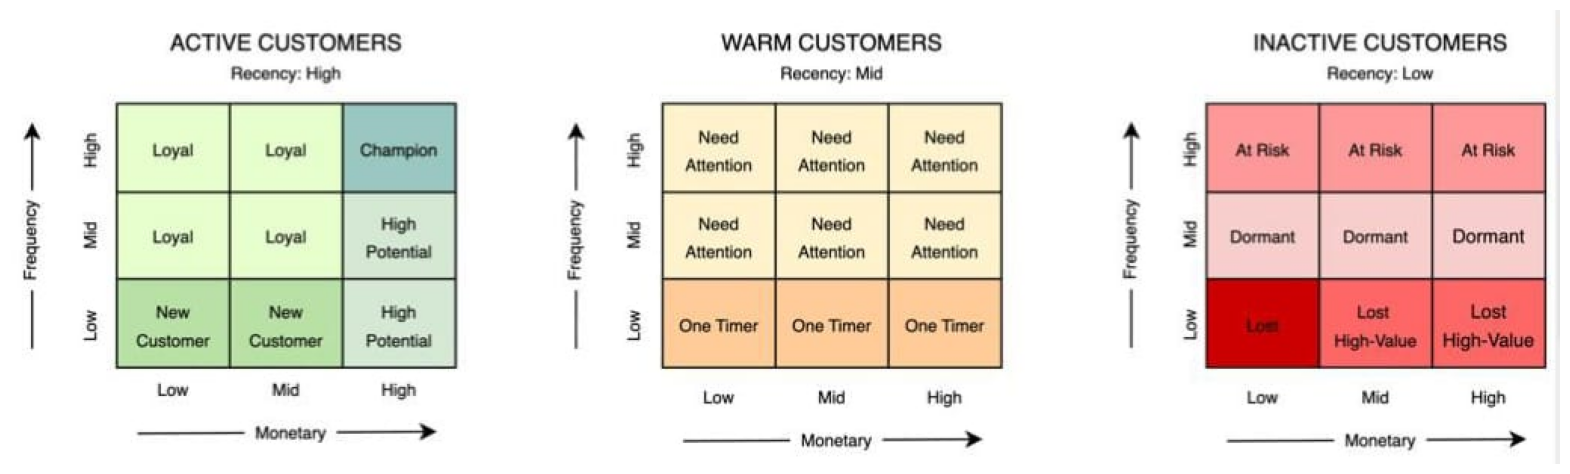

In [0]:
img_path = '/Workspace/Users/filippopedrini95@gmail.com/RFM_diagram.jpeg'  # update with the correct path
img = Image.open(img_path)
plt.figure(figsize=(20, 6))  # change the size here (width, height)
plt.imshow(img)
plt.axis('off')
plt.show()

In [0]:
#LABELLING FUNCTION

#dictionary with "ACTIVE CUSTOMERS" labels
ActiveC_dict = {
#      F      M
    ('low', 'low'): 'new customer',
    ('low', 'mid'): 'new customer',
    ('low', 'high'): 'high potential',

#      F      M
    ('mid', 'low'): 'loyal',
    ('mid', 'mid'): 'loyal',
    ('mid', 'high'): 'high potential',

#      F      M
    ('high', 'low'): 'loyal',
    ('high', 'mid'): 'loyal',
    ('high', 'high'): 'champion'    
}

#dictionary with "WARM CUSTOMERS" labels
WarmC_dict = {
#      F      M
    ('low', 'low'): 'one timer',
    ('low', 'mid'): 'one timer',
    ('low', 'high'): 'one timer',

#      F      M
    ('mid', 'low'): 'need attention',
    ('mid', 'mid'): 'need attention',
    ('mid', 'high'): 'need attention',

#      F      M
    ('high', 'low'): 'need attention',
    ('high', 'mid'): 'need attention',
    ('high', 'high'): 'need attention'  
}


#dictionary with "INACTIVE CUSTOMERS" labels
InactiveC_dict = {
#      F      M
    ('low', 'low'): 'lost',
    ('low', 'mid'): 'lost high-value',
    ('low', 'high'): 'lost high-value',

#      F      M
    ('mid', 'low'): 'dormant',
    ('mid', 'mid'): 'dormant',
    ('mid', 'high'): 'dormant',
#      F      M
    ('high', 'low'): 'at risk',
    ('high', 'mid'): 'at risk',
    ('high', 'high'): 'at risk'
}

# Level assignment function
def Level_Assign(x):
    if x < 3:
        return 'low' # 1 - 2
    elif x == 3:
        return 'mid' # 3
    elif x > 3:
        return 'high' # 4 - 5
    else:
        return np.nan  

#Label assignment function
def RFM_Labeling(row):

    if pd.isnull(row.R):
        return "inactive"
    else:
        M_F = (Level_Assign(row.F), Level_Assign(row.M)) # (high, high)
        R = Level_Assign(row.R)
    
    if R == 'high':
        return ActiveC_dict[M_F]
    elif R == 'mid':
        return WarmC_dict[M_F]
    elif R == 'low':
        return InactiveC_dict[M_F]
    else:
        return np.nan


In [0]:
#TEST THE FUNCTION
a = [[5,1,1, 'new customer'], 
     [5,5,5, 'champion'], 
     [1,1,1, 'lost'], 
     [3,3,3, 'need attention'], 
     [3,1,5, 'one timer'],
     [4,3,5, 'high potential'],
     [4,1,3, 'new customer'],
     [4,4,4, 'champion'],
     [3,4,5, 'need attention'],
     [2,4,2, 'at risk'],
     [1,5,3, 'at risk'],
     [2,3,3, 'dormant'],
     [1,2,3, 'lost high-value']
     ]
x = pd.DataFrame(a, columns=['R', 'F', 'M', 'RFM_label'])
x['assigned label'] = x.apply(RFM_Labeling, axis=1)
x

,R,F,M,RFM_label,assigned label
0,5,1,1,new customer,new customer
1,5,5,5,champion,champion
2,1,1,1,lost,lost
3,3,3,3,need attention,need attention
4,3,1,5,one timer,one timer
5,4,3,5,high potential,high potential
6,4,1,3,new customer,new customer
7,4,4,4,champion,champion
8,3,4,5,need attention,need attention
9,2,4,2,at risk,at risk


In [0]:
#create a labelled RFM series
RFM_label = RFMconc.apply(lambda x: RFM_Labeling(x), axis = 1)
pd.concat([RFMconc, RFM_label], axis=1)

,R,F,M,0
0,5.0,2,4.0,high potential
1,2.0,2,1.0,lost
2,4.0,2,3.0,new customer
3,4.0,5,4.0,champion
4,NaN,1,NaN,inactive
...,...,...,...,...
5993,5.0,4,1.0,loyal
5994,3.0,2,3.0,one timer
5995,5.0,3,2.0,loyal
5996,5.0,1,2.0,new customer


In [0]:
RFM_label.value_counts()

lost               1086
champion            823
need attention      696
inactive            564
loyal               539
dormant             473
new customer        447
one timer           391
high potential      369
lost high-value     359
at risk             251
Name: count, dtype: int64

In [0]:
#add RFM_score and RFM_label to the original dataframe
df['R_score'] = R
df['F_score'] = F
df['M_score'] = M
df['RFM_score'] = RFM_score
df['RFM_label'] = RFM_label

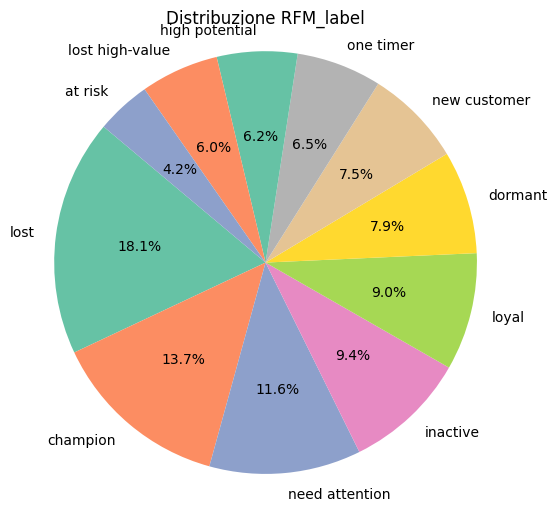

In [0]:
label_counts = df['RFM_label'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('Set2').colors)
plt.title('Distribuzione RFM_label')
plt.axis('equal')
plt.show()

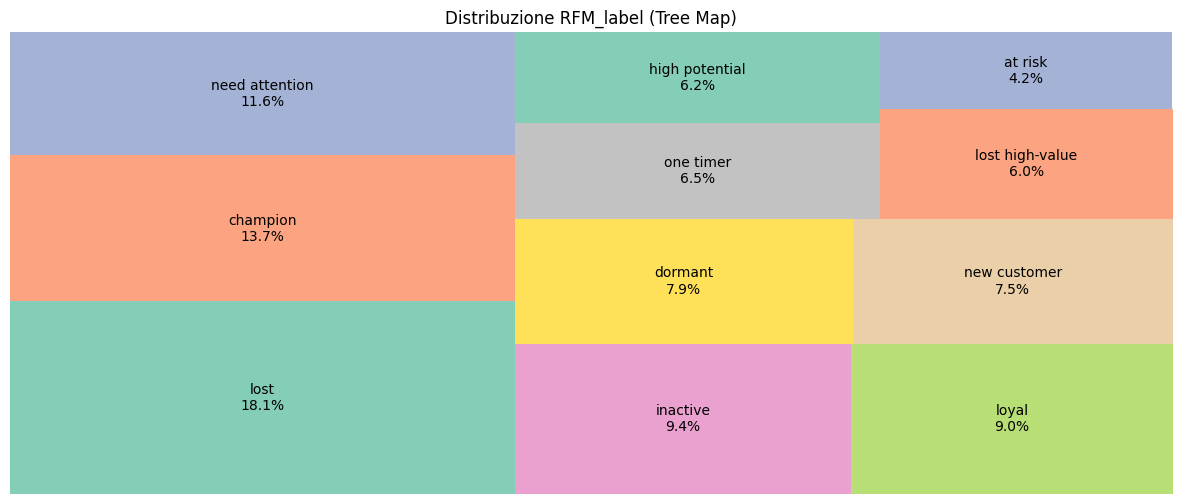

In [0]:
label_counts = df['RFM_label'].value_counts(normalize=True) * 100
labels_with_pct = [f"{label}\n{pct:.1f}%" for label, pct in zip(label_counts.index, label_counts.values)]
plt.figure(figsize=(15, 6))
squarify.plot(sizes=label_counts.values, label=labels_with_pct, color=plt.get_cmap('Set2').colors, alpha=0.8)
plt.title('Distribuzione RFM_label (Tree Map)')
plt.axis('off')
plt.show()

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'hotel_stayed_discount_avg', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date', 'age_in_2023',
       'age_bin', 'user_spend_tot', 'user_spend_avg', 'R_score', 'F_score',
       'M_score', 'RFM_score', 'RFM_label'],
      dtype='object')

This first RFM labelling was replaced by a second one shorter (with fewer labels) because I decided to combine RFM segments with "Booking and Travel Behaviour segmentation" (performed in UserEDA workbook)

### RFM Labelling 2

This second RFM labelling is shorter (with fewer labels) than the first one above because I decided to combine RFM segments with "Booking and Travel Behaviour segmentation" (performed in UserEDA workbook), therefore fewer labels were needed.

THIS IS THEREFORE THE FINAL LABELLING

In [0]:
img_path = '/Workspace/Users/filippopedrini95@gmail.com/RFM diagr2.jpeg'  # update with the correct path
img = Image.open(img_path)
plt.figure(figsize=(20, 6))  # change the size here (width, height)
plt.imshow(img)
plt.axis('off')
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-7393956096005907>, line 2
      1 img_path = '/Workspace/Users/filippopedrini95@gmail.com/RFM diagr2.jpeg'  # update with the correct path
----> 2 img = Image.open(img_path)
      3 plt.figure(figsize=(20, 6))  # change the size here (width, height)
      4 plt.imshow(img)

NameError: name 'Image' is not defined

In [0]:
#LABELLING FUNCTION

#dictionary for high recency
HighRec_dict = {
#      F      M
    ('low', 'low'): 'new / need attention',
    ('low', 'high'): 'high potential',

#      F      M
    ('high', 'low'): 'loyal',
    ('high', 'high'): 'champion'    
}



#dictionary with "INACTIVE CUSTOMERS" labels
LowRec_dict = {
#      F      M
    ('low', 'low'): 'lost',
    ('low', 'high'): 'dormant / one-timer',

#      F      M
    ('high', 'low'): 'at risk',
    ('high', 'high'): 'need attention'
}

# MF Level assignment function
def MF_Level_Assign(x):
    if x < 3:
        return 'low' # 1 - 2
    elif x >= 3:
        return 'high' # 3 - 5
    else:
        return np.nan  

# R Level assignment function
def R_Level_Assign(x):
    if x <= 3:
        return 'low' # 1 - 3
    elif x > 3:
        return 'high' # 4 - 5
    else:
        return np.nan  



#Label assignment function
def RFM_Labeling2(row):
    
    if pd.isnull(row.R):
        return "inactive"
    else:
        M_F = (MF_Level_Assign(row.F), MF_Level_Assign(row.M))
        R = R_Level_Assign(row.R)
    
    if R == 'high':
        return HighRec_dict[M_F]
    elif R == 'low':
        return LowRec_dict[M_F]
    else:
        return np.nan


In [0]:
#TEST THE FUNCTION
a = [[5,1,1, 'new / need attention'], 
     [5,5,5, 'champion'], 
     [1,1,1, 'lost'], 
     [3,3,3, 'need attention'], 
     [3,1,5, 'dormant'],
     [4,3,5, 'champiobn'],
     [4,1,3, 'high potential'],
     [4,4,4, 'champion'],
     [3,4,5, 'need attention'],
     [2,4,2, 'at risk'],
     [1,5,3, 'need attention'],
     [2,3,3, 'need attention'],
     [1,2,3, 'dormant']
     ]
x = pd.DataFrame(a, columns=['R', 'F', 'M', 'RFM_label'])
x['assigned label'] = x.apply(RFM_Labeling2, axis=1)
x

,R,F,M,RFM_label,assigned label
0,5,1,1,new / need attention,new / need attention
1,5,5,5,champion,champion
2,1,1,1,lost,lost
3,3,3,3,need attention,need attention
4,3,1,5,dormant,dormant / one-timer
5,4,3,5,champiobn,champion
6,4,1,3,high potential,high potential
7,4,4,4,champion,champion
8,3,4,5,need attention,need attention
9,2,4,2,at risk,at risk


In [0]:
#create a labelled RFM series
RFM_label2 = RFMconc.apply(lambda x: RFM_Labeling2(x), axis = 1)
pd.concat([RFMconc, RFM_label2], axis=1)

,R,F,M,0
0,5.0,2,4.0,high potential
1,2.0,2,1.0,lost
2,4.0,2,3.0,high potential
3,4.0,5,4.0,champion
4,NaN,1,NaN,inactive
...,...,...,...,...
5993,5.0,4,1.0,loyal
5994,3.0,2,3.0,dormant / one-timer
5995,5.0,3,2.0,loyal
5996,5.0,1,2.0,new / need attention


In [0]:
RFM_label2.value_counts()

champion                1427
lost                    1350
need attention          1144
inactive                 564
dormant / one-timer      486
new / need attention     356
at risk                  276
high potential           203
loyal                    192
Name: count, dtype: int64

In [0]:
#add RFM_score and RFM_label to the original dataframe
df['RFM_label2'] = RFM_label2

## SAVING DATASET

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'hotel_stayed_discount_avg', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date', 'age_in_2023',
       'age_bin', 'user_spend_tot', 'user_spend_avg', 'R_score', 'F_score',
       'M_score', 'RFM_score', 'RFM_label', 'RFM_label2'],
      dtype='object')

In [0]:
%sql
/* to drop the delta lake table, before recreating it*/
DROP TABLE workspace.default.df_users_RFM;

In [0]:
#better to first drop the table, then create it again

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Save as Delta Lake table
spark_df.write.format("delta").mode("overwrite").saveAsTable("df_users_RFM") #TABLE SAVED IN "user_RFM.csv"

#CLTV

**CLTV = Average Order Value × Purchase Frequency × Customer Lifetime**

* Average Order Value (AOV)= Total Monetary Value / Number of Purchases

* Purchase Frequency (PF)=  Number of Purchases / Customer Active Time

* Customer Lifetime -> must be defined yet

CONCLUSION: I tried different ways to obtain a proper CLTV but I was not able so I chose to use only RFM labels and "Booking and Travel Behaviour segmentation" (this was performed in the UserEDA notebook) 

Average Order Value

In [0]:
#AOV: average user spend per "travelled booking"
df.user_spend_avg

0       1901.000000
1        547.045000
2       1320.955000
3        808.132000
4               NaN
           ...     
5993     304.792500
5994    1188.260000
5995     496.986667
5996    1573.790000
5997            NaN
Name: user_spend_avg, Length: 5998, dtype: float64

Purchase Frequency (PF)

In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'hotel_stayed_discount_avg', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date', 'age_in_2023',
       'age_bin', 'user_spend_tot', 'user_spend_avg', 'R_score', 'F_score',
       'M_score', 'RFM_score', 'RFM_label', 'RFM_label2'],
      dtype='object')

In [0]:
df.sign_up_date.apply(['min','max'])

min   2021-07-22
max   2023-05-18
Name: sign_up_date, dtype: datetime64[ns]

In [0]:
#calculation of active days in 2023
active_days_in_2023 = df.apply(lambda row:
    (reference_date - row.sign_up_date).days    #this in case the user signed up in 2023
    if row.sign_up_date.year >= 2023 
    else (reference_date - pd.to_datetime("2023-01-01 00:00:00")).days, #this in case the user signed up before 2023
    axis = 1)


In [0]:
#calculation of frequency by active time (month)
frequency_by_activetime = df.nr_sessions / active_days_in_2023 * (365/12)

In [0]:
frequency_by_activetime.isnull().sum()

np.int64(0)

Customer Lifetime

To estimate customer lifetime, I focus on user engagement, assuming that customers who interact more frequently and more recently with the service are more likely to remain active over time. Since I do not have a direct measure of user satisfaction, I infer behavioral loyalty from recency and frequency indicators.

* Users with high recency scores (i.e. they made a purchase recently) and high frequency show strong engagement with the platform and are therefore more likely to have a longer expected lifetime.

* Frequency is computed as the number of purchases since the beginning of data collection (early 2023), without normalizing by signup date. This choice favors customers with a longer relationship with the platform, while new users are slightly disadvantaged. However, given the limited historical depth of the data, estimating long-term retention for new users is intrinsically uncertain.

* Some users make many short/low-cost trips, while others make very few but expensive ones. While purchase frequency is a meaningful indicator of engagement, customer spend is not necessarily indicative of loyalty in this context. In particular, occasional high-spend users cannot be assumed to be strongly retained, especially given the short observation window. For this reason, monetary value is excluded from lifetime estimation.

* An absolute estimate of customer lifetime cannot be reliably derived from the available data. Therefore, customer lifetime is modeled primarily as a relative measure, reflecting differences in engagement between customers rather than a precise time prediction. Higher recency and purchase frequency indicate a longer relative lifetime. To give this measure a practical interpretation, lifetime values are rescaled to a plausible horizon: assuming that, in the best-case scenario, future activity may extend up to twice the observed period (which is ~7 months), a maximum lifetime of 14 months is assumed. Lifetime is thus mapped to a range between 1 and 14 months based on recency and frequency scores. This scaling is assumption-based and not data-driven, but it preserves the relative comparability between customers.

* First, a lifetime index is computed as _lifetime_index = 0.6 × R + 0.4 × F_, assigning slightly more weight to recency in order to favor customers who are currently more active over those who were frequent in the past. This index is then linearly rescaled so that its minimum corresponds to a lifetime of 1 month and its maximum to 14 months.


In [0]:
df.columns

Index(['user_id', 'nr_sessions', 'date_last_booking_travelled',
       'page_clicks_tot', 'page_clicks_avg', 'flights_taken', 'hotels_stayed',
       'nr_booked_and_travelled', 'nr_booked_but_cancelled',
       'nr_cancellation_session', 'nr_no_booking', 'flight_taken_discount_avg',
       'hotel_stayed_discount_avg', 'flight_taken_price_avg',
       'hotel_stayed_room_price_per_night_avg', 'hotel_stayed_nights_avg',
       'nr_airlines_taken', 'distance_km_tot', 'distance_km_avg',
       'duration_tot', 'duration_avg', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date', 'age_in_2023',
       'age_bin', 'user_spend_tot', 'user_spend_avg', 'R_score', 'F_score',
       'M_score', 'RFM_score', 'RFM_label', 'RFM_label2'],
      dtype='object')

In [0]:
lifetime_index = 0.6 * R.replace({np.nan: 1}) + 0.4 * F.replace({np.nan: 1}) 
lifetime_index.apply(['min', 'max'])

#R and F null are replaced with the lowest R and F score, i.e. 1. We are assuming that those users who have done no purchase yet have the same lifetime of those who have the lowest recency and frequency.

min    1.0
max    5.0
dtype: float64

In [0]:
lifetime_months = lifetime_index.apply(lambda x: (13*x-9)/4)
lifetime_months

0       10.10
1        4.25
2        8.15
3       12.05
4        1.00
        ...  
5993    12.70
5994     6.20
5995    11.40
5996     8.80
5997     1.00
Length: 5998, dtype: float64

CLTV calculation

In [0]:
cltv_score = df.user_spend_avg.replace({np.nan: 0}) * frequency_by_activetime * lifetime_months
cltv_score.apply(['min', 'max'])

#some user spend avg sono NaN...le ho sostituite con 0. Verifica che vada bene

min         0.000000
max    209212.193747
dtype: float64

In [0]:
cltv_score[cltv_score > 0].apply(['min', 'max'])

min        52.136462
max    209212.193747
dtype: float64

In [0]:
cltv_score.shape

(5998,)

In [0]:
cltv_score[cltv_score == 0].shape

(564,)

Text(0, 0.5, 'Frequency')

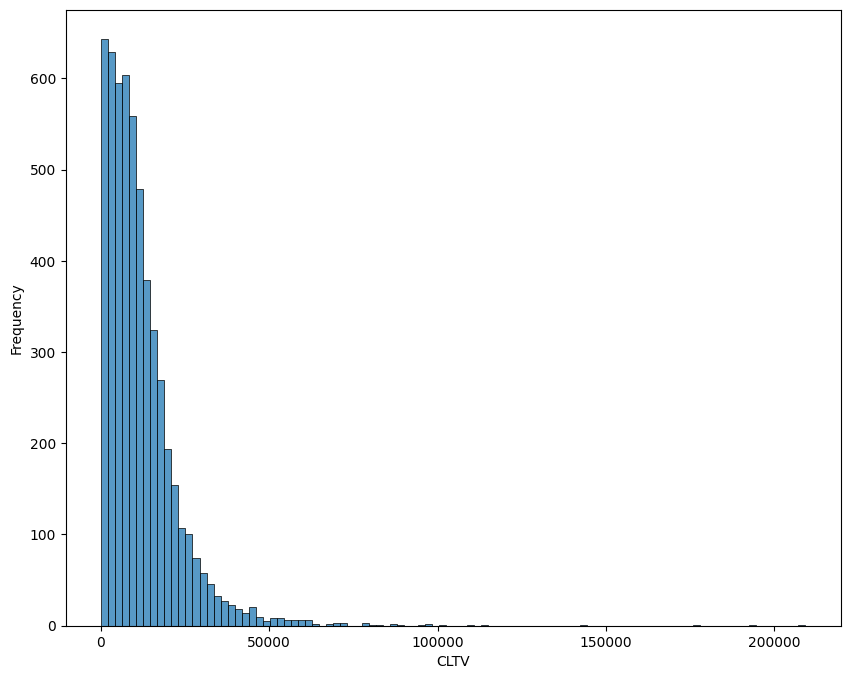

In [0]:
plt.figure(figsize=(10,8))
sns.histplot(cltv_score[cltv_score > 0], bins=100)
plt.xlabel("CLTV")
plt.ylabel("Frequency")

##Lifetime Estimate

In [0]:
#let's take all years to estimate average lifetime
sessions_spark = spark.sql("""
                                    
WITH sessions AS (
  SELECT *
  FROM sessions_spark
),

filtered_users AS (
  SELECT
    user_id,
    COUNT(*) AS session_count
  FROM sessions
  GROUP BY user_id
  HAVING COUNT(*) > 7
),

session_base AS (
  SELECT

    s.session_id,
    s.user_id,
    s.trip_id,
    s.session_start, s.session_end,
    /*s.page_clicks,
    s.flight_discount, s.flight_discount_amount,
    s.hotel_discount, s.hotel_discount_amount,
    s.flight_booked, s.hotel_booked,*/
    s.cancellation,

    /*u.birthdate, u.gender, u.married, u.has_children,
    u.home_country, u.home_city, u.home_airport,
    u.home_airport_lat, u.home_airport_lon,*/
    u.sign_up_date

    /*f.origin_airport, f.destination, f.destination_airport,
    f.seats, f.return_flight_booked,
    f.departure_time, f.return_time,
    f.checked_bags, f.trip_airline,
    f.destination_airport_lat, f.destination_airport_lon,
    f.base_fare_usd,

    h.hotel_name, h.nights, h.rooms,
    h.check_in_time, h.check_out_time,
    h.hotel_per_room_usd AS hotel_price_per_room_night_usd*/

  FROM sessions s
  
  INNER JOIN users_spark u ON s.user_id = u.user_id
  /*LEFT JOIN flights_spark f ON s.trip_id = f.trip_id
  LEFT JOIN hotels_spark h ON s.trip_id = h.trip_id*/
  
  WHERE s.user_id IN (SELECT user_id FROM filtered_users)
)
SELECT *
FROM session_base
""")

AllTimeS_df = sessions_spark.toPandas()

In [0]:
AllTimeS_df.trip_id.value_counts().value_counts()

count
1    675398
2     27052
Name: count, dtype: int64

In [0]:
trip_id_twice = AllTimeS_df.trip_id.value_counts()[AllTimeS_df.trip_id.value_counts() == 2].index

In [0]:
AllTimeS_df.loc[(AllTimeS_df.trip_id.isin(trip_id_twice)) & (AllTimeS_df.cancellation == False), 'trip_id'].nunique()
#from here you can see that those trip_id appearing twice are from booked but cancelled trips (first time is booking, second time is cancellation session)

27052

status labelling

In [0]:
booked_and_travelled_indexes = AllTimeS_df[(AllTimeS_df.trip_id.notnull()) & (AllTimeS_df.cancellation == False) & (~AllTimeS_df.trip_id.isin(trip_id_twice))].index

booked_but_cancelled_indexes = AllTimeS_df[(AllTimeS_df.trip_id.notnull()) & (AllTimeS_df.cancellation == False) & (AllTimeS_df.trip_id.isin(trip_id_twice))].index

cancellation_session_indexes = AllTimeS_df[(AllTimeS_df.trip_id.notnull()) & (AllTimeS_df.cancellation == True) & (AllTimeS_df.trip_id.isin(trip_id_twice))].index

no_booking_indexes = AllTimeS_df[(AllTimeS_df.trip_id.isnull())].index

In [0]:
AllTimeS_df['status'] = pd.Series([None] * len(AllTimeS_df), dtype='object')
AllTimeS_df.iloc[booked_and_travelled_indexes, AllTimeS_df.columns.get_loc('status')] = 'booked_and_travelled'
AllTimeS_df.iloc[booked_but_cancelled_indexes, AllTimeS_df.columns.get_loc('status')] = 'booked_but_cancelled'
AllTimeS_df.iloc[cancellation_session_indexes, AllTimeS_df.columns.get_loc('status')] = 'cancellation_session'
AllTimeS_df.iloc[no_booking_indexes, AllTimeS_df.columns.get_loc('status')] = 'no_booking'

users with last session older than 2023

In [0]:
session_end_by_user = AllTimeS_df.groupby('user_id')['session_end'].max()
user_id_lastsessionbefore2023 = session_end_by_user[session_end_by_user.dt.year < 2023].index

In [0]:
sessions_2023InactiveUser_df = AllTimeS_df[AllTimeS_df.user_id.isin(user_id_lastsessionbefore2023)]

In [0]:
sessions_2023InactiveUser_df.status.value_counts()

status
no_booking              55215
booked_and_travelled    35160
cancellation_session     1435
booked_but_cancelled     1435
Name: count, dtype: int64

In [0]:
#removing "cancellation session" since they are the only one that we can't consider positive interaction with the platform
sessions_2023IU_woCanc_df = sessions_2023InactiveUser_df[sessions_2023InactiveUser_df.status != 'cancellation_session']

In [0]:
sessions_2023IU_woCanc_df = sessions_2023IU_woCanc_df.sort_values(by=['user_id', 'session_start']).reset_index(drop=True)
sessions_2023IU_woCanc_df.head(5)

,session_id,user_id,trip_id,session_start,session_end,cancellation,sign_up_date,status
0,6-8221282e0e894e9ea64ac4f9ba7b7477,6,None,2021-04-01 15:03:00,2021-04-01 15:04:08,False,2021-04-01,no_booking
1,6-cec4239e791740dd84a240664f28a47d,6,None,2021-04-02 20:25:00,2021-04-02 20:26:22,False,2021-04-01,no_booking
2,6-bbf33eac16564ed7a4c2b0968892d0c5,6,None,2021-04-07 21:54:00,2021-04-07 21:54:53,False,2021-04-01,no_booking
3,6-6d1868564c254b278e2110e360b4b3eb,6,None,2021-06-08 14:04:00,2021-06-08 14:04:59,False,2021-04-01,no_booking
4,6-53fa9ec070b14a5e8c68bfe6d132fc4f,6,6-a25a7e7f24d04dca9ace938e5e09e33c,2021-07-31 20:08:00,2021-07-31 20:10:19,False,2021-04-01,booked_and_travelled


In [0]:
sessions_2023IU_woCanc_df['prev_user_id'] = sessions_2023IU_woCanc_df['user_id'].shift(1)
sessions_2023IU_woCanc_df['prev_session_end'] = sessions_2023IU_woCanc_df['session_end'].shift(1)

In [0]:
sessions_2023IU_woCanc_df['days_between_sessions'] = sessions_2023IU_woCanc_df.apply(
        lambda row: (row.session_start - row.prev_session_end).total_seconds()/86400
        if row.prev_user_id == row.user_id
        else None,
        axis=1)

In [0]:
sessions_2023IU_woCanc_df[['user_id', 'session_start', 'session_end', 'prev_user_id', 'prev_session_end', 'days_between_sessions']].head(10)

,user_id,session_start,session_end,prev_user_id,prev_session_end,days_between_sessions
0,6,2021-04-01 15:03:00,2021-04-01 15:04:08,NaN,NaT,NaN
1,6,2021-04-02 20:25:00,2021-04-02 20:26:22,6.0,2021-04-01 15:04:08,1.222824
2,6,2021-04-07 21:54:00,2021-04-07 21:54:53,6.0,2021-04-02 20:26:22,5.060856
3,6,2021-06-08 14:04:00,2021-06-08 14:04:59,6.0,2021-04-07 21:54:53,61.672998
4,6,2021-07-31 20:08:00,2021-07-31 20:10:19,6.0,2021-06-08 14:04:59,53.252095
5,6,2021-10-20 02:25:00,2021-10-20 02:26:07,6.0,2021-07-31 20:10:19,80.260197
6,6,2022-01-11 16:26:00,2022-01-11 16:31:32,6.0,2021-10-20 02:26:07,83.583252
7,6,2022-03-19 15:46:00,2022-03-19 15:47:41,6.0,2022-01-11 16:31:32,66.968380
8,6,2022-03-31 17:44:00,2022-03-31 17:45:14,6.0,2022-03-19 15:47:41,12.080775
9,6,2022-11-20 11:21:00,2022-11-20 11:21:23,6.0,2022-03-31 17:45:14,233.733171


In [0]:
sessions_2023IU_woCanc_df.drop(columns=['prev_user_id', 'prev_session_end'], inplace = True)

In [0]:
sessions_2023IU_woCanc_df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'cancellation', 'sign_up_date', 'status', 'days_between_sessions'],
      dtype='object')

In [0]:
sessions_2023IU_woCanc_df['days_since_signup'] = pd.to_timedelta(sessions_2023IU_woCanc_df['session_start'] - sessions_2023IU_woCanc_df['sign_up_date']).dt.total_seconds()/86400

In [0]:
sessions_2023IU_woCanc_df[['user_id', 'session_start', 'sign_up_date', 'days_since_signup']].head(5)

,user_id,session_start,sign_up_date,days_since_signup
0,6,2021-04-01 15:03:00,2021-04-01,0.627083
1,6,2021-04-02 20:25:00,2021-04-01,1.850694
2,6,2021-04-07 21:54:00,2021-04-01,6.912500
3,6,2021-06-08 14:04:00,2021-04-01,68.586111
4,6,2021-07-31 20:08:00,2021-04-01,121.838889


<Axes: xlabel='days_since_signup'>

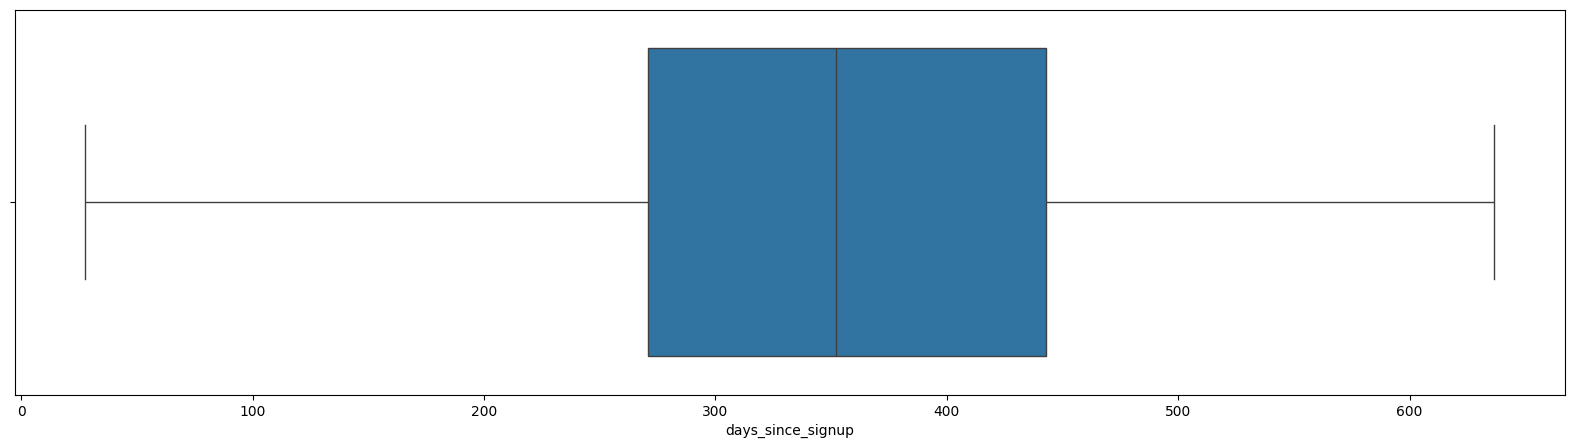

In [0]:
plt.figure(figsize=(20,5))
sns.boxplot(x = sessions_2023IU_woCanc_df.groupby('user_id')['days_since_signup'].max())

In [0]:
#last session date
sessions_2023IU_woCanc_df['last_session_date'] = sessions_2023IU_woCanc_df.groupby('user_id')['session_end'].transform('max')

In [0]:
#days to last session
sessions_2023IU_woCanc_df['days_to_lastsession'] = pd.to_timedelta(sessions_2023IU_woCanc_df['last_session_date'] - sessions_2023IU_woCanc_df['session_end']).dt.total_seconds()/86400

In [0]:
sessions_userlast30days_df = sessions_2023IU_woCanc_df[sessions_2023IU_woCanc_df['days_to_lastsession'] <= 30]
sessions_userlast60days_df = sessions_2023IU_woCanc_df[sessions_2023IU_woCanc_df['days_to_lastsession'] <= 60]
sessions_userlast90days_df = sessions_2023IU_woCanc_df[sessions_2023IU_woCanc_df['days_to_lastsession'] <= 90]
sessions_userlast200days_df = sessions_2023IU_woCanc_df[sessions_2023IU_woCanc_df['days_to_lastsession'] <= 200]

In [0]:
freq30days = sessions_userlast30days_df.groupby('user_id')['session_id'].count()

In [0]:
freq60days = sessions_userlast60days_df.groupby('user_id')['session_id'].count()

In [0]:
freq90days = sessions_userlast90days_df.groupby('user_id')['session_id'].count()

In [0]:
freq200days = sessions_userlast200days_df.groupby('user_id')['session_id'].count()

In [0]:
sessions_2023IU_woCanc_df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'cancellation', 'sign_up_date', 'status', 'days_between_sessions',
       'days_since_signup', 'last_session_date', 'days_to_lastsession'],
      dtype='object')

In [0]:
sessions_2023IU_woCanc_df[['user_id', 'days_between_sessions']].head(30)

,user_id,days_between_sessions
0,6,NaN
1,6,1.222824
2,6,5.060856
3,6,61.672998
4,6,53.252095
5,6,80.260197
6,6,83.583252
7,6,66.968380
8,6,12.080775
9,6,233.733171


In [0]:
#assigning number of sequence by user
counter = 0
result = []

for val in sessions_2023IU_woCanc_df['days_between_sessions']:
    if pd.isnull(val):
        counter = 0
        result.append(counter)
    else:
        counter += 1
        result.append(counter)

sessions_2023IU_woCanc_df['user_session_nr'] = result

per ciascun utente attivo calcola recency, frequenza ed eta'. Crea poi una funzione che entra nel database contenente le sessioni churned, e ricerca quegli utenti che avevano a quell'eta' la medesima recency e frequenza (o comunque simile) e fai la media delle lifetime di ciascuno, da usare come stima per la lifetime dell'utente attivo.

In [0]:
#user frequency at the session
sessions_2023IU_woCanc_df['frequency_at_session'] = sessions_2023IU_woCanc_df.apply(lambda row: row.user_session_nr / row.days_since_signup if row.user_session_nr > 0 else 0, axis=1)

In [0]:
sessions_2023IU_woCanc_df.head(30)

,session_id,user_id,trip_id,session_start,session_end,cancellation,sign_up_date,status,days_between_sessions,days_since_signup,last_session_date,days_to_lastsession,user_session_nr,frequency_at_session
0,6-8221282e0e894e9ea64ac4f9ba7b7477,6,None,2021-04-01 15:03:00,2021-04-01 15:04:08,False,2021-04-01,no_booking,NaN,0.627083,2022-12-12 13:07:28,619.918981,0,0.000000
1,6-cec4239e791740dd84a240664f28a47d,6,None,2021-04-02 20:25:00,2021-04-02 20:26:22,False,2021-04-01,no_booking,1.222824,1.850694,2022-12-12 13:07:28,618.695208,1,0.540338
2,6-bbf33eac16564ed7a4c2b0968892d0c5,6,None,2021-04-07 21:54:00,2021-04-07 21:54:53,False,2021-04-01,no_booking,5.060856,6.912500,2022-12-12 13:07:28,613.633738,2,0.289331
3,6-6d1868564c254b278e2110e360b4b3eb,6,None,2021-06-08 14:04:00,2021-06-08 14:04:59,False,2021-04-01,no_booking,61.672998,68.586111,2022-12-12 13:07:28,551.960058,3,0.043741
4,6-53fa9ec070b14a5e8c68bfe6d132fc4f,6,6-a25a7e7f24d04dca9ace938e5e09e33c,2021-07-31 20:08:00,2021-07-31 20:10:19,False,2021-04-01,booked_and_travelled,53.252095,121.838889,2022-12-12 13:07:28,498.706354,4,0.032830
5,6-33d9a400ed4a4e39a14ced713a3cac00,6,None,2021-10-20 02:25:00,2021-10-20 02:26:07,False,2021-04-01,no_booking,80.260197,202.100694,2022-12-12 13:07:28,418.445382,5,0.024740
6,6-99781c84077c4fac9cb1b73dccc2f3f1,6,None,2022-01-11 16:26:00,2022-01-11 16:31:32,False,2021-04-01,no_booking,83.583252,285.684722,2022-12-12 13:07:28,334.858287,6,0.021002
7,6-97a4e53c92b1453dbf426e2ddeb25a2b,6,None,2022-03-19 15:46:00,2022-03-19 15:47:41,False,2021-04-01,no_booking,66.968380,352.656944,2022-12-12 13:07:28,267.888738,7,0.019849
8,6-6b304f7c73d44c4480110f594383946a,6,6-6756ac3ed2b74b678794363680f3c3a0,2022-03-31 17:44:00,2022-03-31 17:45:14,False,2021-04-01,booked_and_travelled,12.080775,364.738889,2022-12-12 13:07:28,255.807106,8,0.021933
9,6-10424b6f7fa6439c9b3ed42d24d45d8f,6,None,2022-11-20 11:21:00,2022-11-20 11:21:23,False,2021-04-01,no_booking,233.733171,598.472917,2022-12-12 13:07:28,22.073669,9,0.015038


In [0]:
sessions_2023IU_woCanc_df.frequency_at_session.describe()

count    91810.000000
mean         0.055319
std          0.086338
min          0.000000
25%          0.020887
50%          0.032000
75%          0.056008
max          0.992419
Name: frequency_at_session, dtype: float64

In [0]:
sessions_2023IU_woCanc_df.days_between_sessions.describe()

count    81262.000000
mean        45.980171
std         50.919525
min          0.081863
25%         12.910443
50%         27.789578
75%         60.149714
max        461.732477
Name: days_between_sessions, dtype: float64

In [0]:
sessions_2023IU_woCanc_df.days_since_signup.describe()

count    91810.000000
mean       136.464515
std        133.849398
min          0.000000
25%         21.894444
50%         96.793056
75%        216.692187
max        636.672917
Name: days_since_signup, dtype: float64

In [0]:
sessions_2023IU_woCanc_df[sessions_2023IU_woCanc_df.user_id == 7102]

,session_id,user_id,trip_id,session_start,session_end,cancellation,sign_up_date,status,days_between_sessions,days_since_signup,last_session_date,days_to_lastsession,user_session_nr,frequency_at_session
9814,7102-25b344f37e954db9b14159c69f77cfd5,7102,None,2021-06-13 20:20:00,2021-06-13 20:21:13,False,2021-06-13,no_booking,NaN,0.847222,2022-12-28 16:33:31,562.841875,0,0.000000
9815,7102-cafc1d9dacaa487ca2e870498affa023,7102,None,2021-06-16 20:33:00,2021-06-16 20:35:08,False,2021-06-13,no_booking,3.008183,3.856250,2022-12-28 16:33:31,559.832211,1,0.259319
9816,7102-629e10108d414c6bbf5fc79a9c37fc81,7102,None,2021-07-01 11:52:00,2021-07-01 11:52:59,False,2021-06-13,no_booking,14.636713,18.494444,2022-12-28 16:33:31,545.194815,2,0.108141
9817,7102-f8dbe8cadb024d33a554be61c7ce98ac,7102,None,2021-07-18 20:37:00,2021-07-18 20:37:24,False,2021-06-13,no_booking,17.363900,35.859028,2022-12-28 16:33:31,527.830637,3,0.083661
9818,7102-b99fd0d0cd9047ea98175481fab8e73c,7102,None,2021-08-15 21:45:00,2021-08-15 21:45:45,False,2021-06-13,no_booking,28.046944,63.906250,2022-12-28 16:33:31,499.783171,4,0.062592
9819,7102-70775dfbfe594d35ad6f9598fc2d386a,7102,7102-f735b16a78834d6f84593db8bdb7f414,2021-08-30 08:45:00,2021-08-30 08:46:14,False,2021-06-13,booked_but_cancelled,14.457812,78.364583,2022-12-28 16:33:31,485.324502,5,0.063804
9820,7102-ebcb4ace83c3408889553e95bad3b83f,7102,7102-518dff8ae5da4015ae9b21633e60675e,2022-12-05 02:21:00,2022-12-05 02:22:25,False,2021-06-13,booked_and_travelled,461.732477,540.097917,2022-12-28 16:33:31,23.591042,6,0.011109
9821,7102-cc24b052ae5340a389b7906061ff72a2,7102,None,2022-12-28 16:32:00,2022-12-28 16:33:31,False,2021-06-13,no_booking,23.589988,563.688889,2022-12-28 16:33:31,0.000000,7,0.012418


In [0]:
sessions_2023IU_woCanc_df.head(5)

,session_id,user_id,trip_id,session_start,session_end,cancellation,sign_up_date,status,days_between_sessions,days_since_signup,last_session_date,days_to_lastsession,user_session_nr,frequency_at_session
0,6-8221282e0e894e9ea64ac4f9ba7b7477,6,None,2021-04-01 15:03:00,2021-04-01 15:04:08,False,2021-04-01,no_booking,NaN,0.627083,2022-12-12 13:07:28,619.918981,0,0.000000
1,6-cec4239e791740dd84a240664f28a47d,6,None,2021-04-02 20:25:00,2021-04-02 20:26:22,False,2021-04-01,no_booking,1.222824,1.850694,2022-12-12 13:07:28,618.695208,1,0.540338
2,6-bbf33eac16564ed7a4c2b0968892d0c5,6,None,2021-04-07 21:54:00,2021-04-07 21:54:53,False,2021-04-01,no_booking,5.060856,6.912500,2022-12-12 13:07:28,613.633738,2,0.289331
3,6-6d1868564c254b278e2110e360b4b3eb,6,None,2021-06-08 14:04:00,2021-06-08 14:04:59,False,2021-04-01,no_booking,61.672998,68.586111,2022-12-12 13:07:28,551.960058,3,0.043741
4,6-53fa9ec070b14a5e8c68bfe6d132fc4f,6,6-a25a7e7f24d04dca9ace938e5e09e33c,2021-07-31 20:08:00,2021-07-31 20:10:19,False,2021-04-01,booked_and_travelled,53.252095,121.838889,2022-12-12 13:07:28,498.706354,4,0.032830


In [0]:
sessions_2023IU_woCanc_df['user_lifetime'] = sessions_2023IU_woCanc_df.groupby('user_id')['days_since_signup'].transform('max')

In [0]:
sessions_light_df = sessions_2023IU_woCanc_df[['days_since_signup', 'frequency_at_session', 'days_between_sessions' , 'user_lifetime']]
sessions_light_df.head(10)

,days_since_signup,frequency_at_session,days_between_sessions,user_lifetime
0,0.627083,0.000000,NaN,620.545833
1,1.850694,0.540338,1.222824,620.545833
2,6.912500,0.289331,5.060856,620.545833
3,68.586111,0.043741,61.672998,620.545833
4,121.838889,0.032830,53.252095,620.545833
5,202.100694,0.024740,80.260197,620.545833
6,285.684722,0.021002,83.583252,620.545833
7,352.656944,0.019849,66.968380,620.545833
8,364.738889,0.021933,12.080775,620.545833
9,598.472917,0.015038,233.733171,620.545833


In [0]:
#frequency labelling
nr_splits_f = 15

max_f = sessions_2023IU_woCanc_df.frequency_at_session.max()

freq_split_boundaries = list(sessions_2023IU_woCanc_df.frequency_at_session.quantile([i/nr_splits_f for i in range(1, nr_splits_f)]).values)
freq_split_boundaries.append(max_f)


def prime_n_lettere(n):
    return list(string.ascii_lowercase[:n])


freq_letter = prime_n_lettere(nr_splits_f)


def freq_assign(x):
    for i in range(nr_splits_f):
        if x <= freq_split_boundaries[i]:
            return freq_letter[i]

#freq_split_boundaries

In [0]:
#age labelling
#nr_splits_a = 15

#max_f = sessions_2023IU_woCanc_df.days_since_signup.max()

#age_split_boundaries = list(sessions_2023IU_woCanc_df.days_since_signup.quantile([i/nr_splits_a for i in range(1, nr_splits_a)]).values)
#age_split_boundaries.append(max_f)



#def prime_n_lettere(n):
 #   return list(string.ascii_lowercase[:n])


#age_letter = prime_n_lettere(nr_splits_a)


#def age_assign(x):
 #   for i in range(nr_splits_a):
  #      if x <= age_split_boundaries[i]:
   #         return age_letter[i]

age_split_boundaries = [0, ]



In [0]:
age_split_boundaries

[0]

0–30 / 30–90 / 90–180 / 180–365 / >365 è una scelta solida e difendibile.

In [0]:
sessions_2023IU_woCanc_df.days_since_signup.describe()

count    91810.000000
mean       136.464515
std        133.849398
min          0.000000
25%         21.894444
50%         96.793056
75%        216.692187
max        636.672917
Name: days_since_signup, dtype: float64

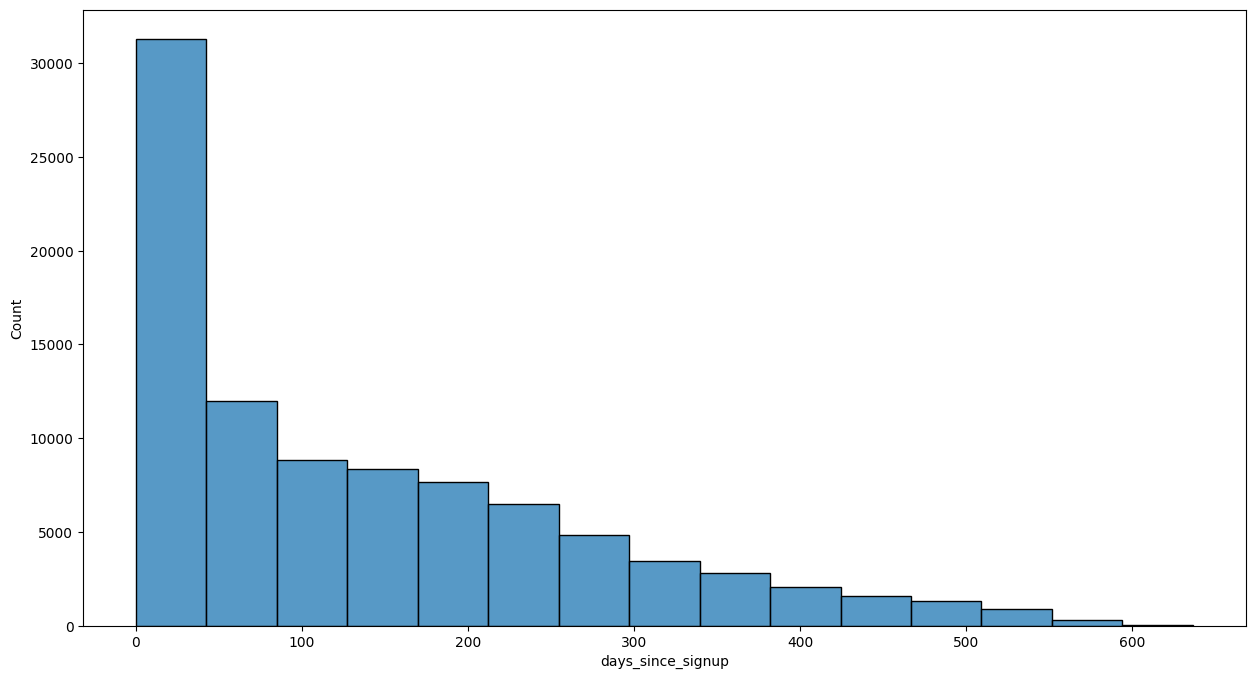

In [0]:
plt.figure(figsize=(15,8))
sns.histplot(sessions_2023IU_woCanc_df.days_since_signup, bins=15)
plt.show()

In [0]:
#recency labelling
nr_splits_r = 15

max_f = sessions_2023IU_woCanc_df.days_between_sessions.max()

rec_split_boundaries = list(sessions_2023IU_woCanc_df.days_between_sessions.quantile([i/nr_splits_r for i in range(1, nr_splits_r)]).values)
rec_split_boundaries.append(max_f)


def prime_n_lettere(n):
    return list(string.ascii_lowercase[:n])


rec_letter = prime_n_lettere(nr_splits_r)


def rec_assign(x):
    for i in range(nr_splits_r):
        if x <= rec_split_boundaries[i]:
            return rec_letter[i]

#rec_split_boundaries

In [0]:
sessions_light_df.head(5)

,days_since_signup,frequency_at_session,days_between_sessions,user_lifetime
0,0.627083,0.000000,NaN,620.545833
1,1.850694,0.540338,1.222824,620.545833
2,6.912500,0.289331,5.060856,620.545833
3,68.586111,0.043741,61.672998,620.545833
4,121.838889,0.032830,53.252095,620.545833


In [0]:
#sessions_light_df['age_lab'] = sessions_light_df.apply(lambda row: age_assign(row.days_since_signup), axis=1)
#sessions_light_df['freq_lab'] = sessions_light_df.apply(lambda row: freq_assign(row.frequency_at_session), axis=1)
#sessions_light_df['rec_lab'] = sessions_light_df.apply(lambda row: rec_assign(row.days_between_sessions), axis=1)

#lifetime_estimator_df = sessions_light_df[['age_lab', 'freq_lab', 'rec_lab', 'user_lifetime']].dropna().reset_index(drop=True)

In [0]:
#lifetime_estimator_df['AFR'] = lifetime_estimator_df.apply(lambda row: f"{row['age_lab']}{row['freq_lab']}{row['rec_lab']}", axis=1)

In [0]:
#AFR_count = lifetime_estimator_df.groupby('AFR')['user_lifetime'].count()
#AFR_count.describe()

In [0]:
#lifetime_estimator_df.groupby('AFR')['user_lifetime'].apply(lambda x: np.std(x) / np.mean(x)).describe()

In [0]:
#sessions_light_df

## ML

In [0]:
sessions_ML_df = sessions_light_df[['days_since_signup', 'frequency_at_session', 'days_between_sessions']]
sessions_ML_df['time_from_state_to_churn'] = sessions_light_df.user_lifetime - sessions_light_df.days_since_signup
sessions_ML_df.dropna(inplace=True)
sessions_ML_df.head(5)

,days_since_signup,frequency_at_session,days_between_sessions,time_from_state_to_churn
1,1.850694,0.540338,1.222824,618.695139
2,6.912500,0.289331,5.060856,613.633333
3,68.586111,0.043741,61.672998,551.959722
4,121.838889,0.032830,53.252095,498.706944
5,202.100694,0.024740,80.260197,418.445139


In [0]:
X = sessions_ML_df.drop(columns=['time_from_state_to_churn'])
y = sessions_ML_df.time_from_state_to_churn

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=30, shuffle = True)

In [0]:
y_train

63761    179.359028
23573    201.145139
37919    145.299306
7204     393.937500
17208    133.574306
            ...    
74970    323.168056
52090    422.738194
54148    253.810417
79057    319.593056
43590    294.891667
Name: time_from_state_to_churn, Length: 65009, dtype: float64

In [0]:

# 1. Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=30, max_depth=2, max_features=None, bootstrap=True)

# 2. Train (fit) the model
rf.fit(X_train, y_train)

# 3. Predict
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

# 4. Get feature importances
importances = rf.feature_importances_



In [0]:

print("--- Test Dataset ---------------------------------")
print(f"mse = {mean_squared_error(y_test, y_pred)}")
print(f"mae = {mean_absolute_error(y_test, y_pred)}")
print(f"r2 = {r2_score(y_test, y_pred)}")

print("\n--- Train Dataset ---------------------------------")
print(f"mse = {mean_squared_error(y_train, y_train_pred)}")
print(f"mae = {mean_absolute_error(y_train, y_train_pred)}")
print(f"r2 = {r2_score(y_train, y_train_pred)}")


--- Test Dataset ---------------------------------
mse = 11295.591788805657
mae = 87.18883567390787
r2 = 0.4467023529019948

--- Train Dataset ---------------------------------
mse = 11225.061577067436
mae = 87.04625906038952
r2 = 0.4493113724931814


In [0]:

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='minkowski', p=2)

knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)


In [0]:

print("--- Test Dataset ---------------------------------")
print(f"mse = {mean_squared_error(y_test, y_pred)}")
print(f"mae = {mean_absolute_error(y_test, y_pred)}")
print(f"r2 = {r2_score(y_test, y_pred)}")

print("\n--- Train Dataset ---------------------------------")
print(f"mse = {mean_squared_error(y_train, y_train_pred)}")
print(f"mae = {mean_absolute_error(y_train, y_train_pred)}")
print(f"r2 = {r2_score(y_train, y_train_pred)}")


--- Test Dataset ---------------------------------
mse = 12775.556506147643
mae = 90.48796078672655
r2 = 0.37420849767035425

--- Train Dataset ---------------------------------
mse = 8443.746901861397
mae = 73.39885741461438
r2 = 0.5857594757519548


CONCLUSION: I tried different ways to obtain a proper CLTV but I was not able so I chose to use only RFM labels and "Booking and Travel Behaviour segmentation" (this was performed in the UserEDA notebook) 